# Spectral Reconstruction: ICVL (High Resolution)

In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import spectral as spy
from tqdm import tqdm
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('bgr', ['blue', 'green', 'red'])

## Metrics

In [4]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2, axis=1))

def mrae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true, axis=1)

## Dataset

In [5]:
with open('resources/ICVL-HIRES/train.txt', 'r') as file:
    images_train = [Path(f'datasets/ICVL-HIRES/{it}') for it in file.read().splitlines()]

In [6]:
with open('resources/ICVL-HIRES/test.txt', 'r') as file:
    images_test = [Path(f'datasets/ICVL-HIRES/{it}') for it in file.read().splitlines()]

In [7]:
with open('resources/ICVL-HIRES/val.txt', 'r') as file:
    images_val = [Path(f'datasets/ICVL-HIRES/{it}') for it in file.read().splitlines()]

In [8]:
def load(path: Path):
    envi = spy.io.envi.open(path)
    y = envi[:, 2:, 1:410].astype(np.float64) / 4095.0
    y = y.reshape(-1, y.shape[-1])

    X = np.load(path.with_suffix('.npy'))
    return X, y

In [9]:
envi_ref_path = Path('datasets/ICVL-HIRES/BGU_0522-1127.hdr')
envi_ref = spy.io.envi.open(envi_ref_path)

In [10]:
wavelengths = envi_ref.bands.centers[1:410]
height, width, _ = envi_ref.shape
width -= 2

## Least Squares Regression

In [11]:
class RegressionLS:
    def __init__(self, n_features, n_channels):
        self._n_features = n_features
        self._n_channels = n_channels

        self._XX = np.zeros((self._n_features, self._n_features))
        self._XY = np.zeros((self._n_features, self._n_channels))

        self._M = np.zeros((self._n_features, self._n_channels))
        self.alpha_ = 0.0

    def update(self, X, y):
        self._XX += X.T @ X
        self._XY += X.T @ y

    def build(self, *, alpha=0.0):
        self._M = np.linalg.inv(self._XX + alpha * np.eye(self._n_features)) @ self._XY
        self.alpha_ = alpha

    def transform(self, X):
        return X @ self._M

### Linear Regression

In [12]:
lr_ls_path = Path('models/ICVL_HIRES_LR_LS.pkl')

In [13]:
def train_lr_ls():
    model = RegressionLS(n_features=3, n_channels=len(wavelengths))

    print('Training:')
    for path in tqdm(images_train):
        X, y = load(path)
        model.update(X, y)
        del X, y

    alphas = np.logspace(-14, 5, num=20)
    total_sum = np.zeros_like(alphas)
    total_len = np.zeros_like(alphas)

    print('Validating:')
    for path in tqdm(images_val):
        X, y_true = load(path)

        for i, test_alpha in enumerate(alphas):
            model.build(alpha=test_alpha)
            y_pred = model.transform(X)

            total_sum[i] += mrae(y_true, y_pred).sum()
            total_len[i] += len(X)

            del y_pred

    alpha_costs = total_sum / total_len
    del X, y_true

    model.build(alpha=alphas[np.argmin(alpha_costs)])

    with open(lr_ls_path, 'wb') as file:
        pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

    return model

In [14]:
if lr_ls_path.exists():
    with open(lr_ls_path, 'rb') as file:
        model_lr_ls = pickle.load(file)
else:
    model_lr_ls = train_lr_ls()

In [ ]:
lr_ls_mean_rmse_costs = []
lr_ls_mean_mrae_costs = []

for path in tqdm(images_test):
    X, y_true = load(path)
    y_pred = model_lr_ls.transform(X)

    lr_ls_mean_rmse_costs.append(np.mean(rmse(y_true, y_pred)))
    lr_ls_mean_mrae_costs.append(np.mean(mrae(y_true, y_pred)))

    del X, y_true, y_pred

  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
lr_ls_df = pd.DataFrame({
    'Mean MRAE': lr_ls_mean_mrae_costs,
    'Mean RMSE': lr_ls_mean_rmse_costs,
}, index=images_test)

lr_ls_df.describe()

,Mean MRAE,Mean RMSE
count,3.000000,3.000000
mean,0.105367,0.017247
std,0.030805,0.006284
min,0.080947,0.012075
25%,0.088063,0.013750
50%,0.095179,0.015425
75%,0.117577,0.019833
max,0.139976,0.024241


In [17]:
X, y_true = load(envi_ref_path)
y_pred = model_lr_ls.transform(X)

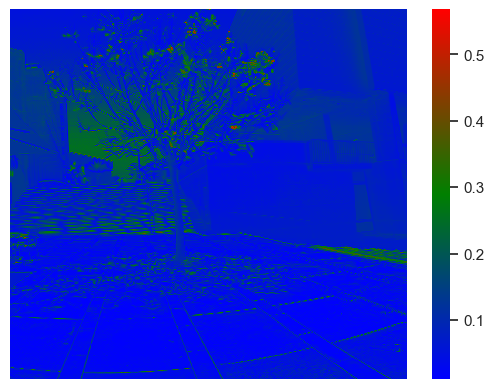

In [18]:
costs_lr_ls = mrae(y_true, y_pred)
costs_lr_ls = np.rot90(costs_lr_ls.reshape(height, width))
sns.heatmap(costs_lr_ls, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()

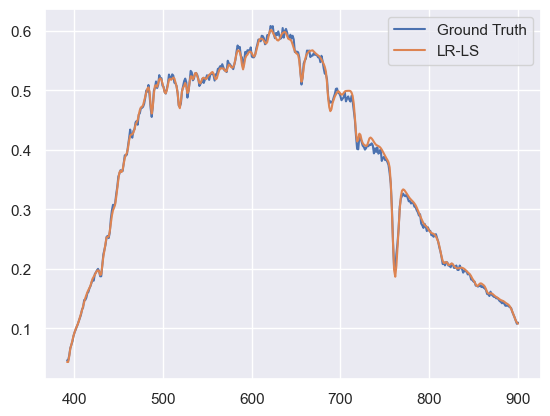

In [19]:
plt.plot(wavelengths, y_true[689675], label='Ground Truth')
plt.plot(wavelengths, y_pred[689675], label='LR-LS')
plt.legend()
plt.show()

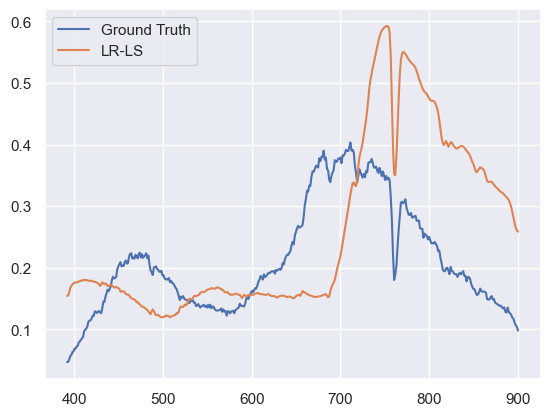

In [20]:
plt.plot(wavelengths, y_true[737945], label='Ground Truth')
plt.plot(wavelengths, y_pred[737945], label='LR-LS')
plt.legend()
plt.show()

In [21]:
del X, y_true, y_pred

### Polynomial Regression

In [22]:
pr_ls_path = Path('models/ICVL_HIRES_PR_LS.pkl')

In [23]:
def train_pr_ls():
    model = RegressionLS(n_features=83, n_channels=len(wavelengths))

    print('Training:')
    for path in tqdm(images_train):
        X, y = load(path)
        X = PolynomialFeatures(6, include_bias=False).fit_transform(X)
        model.update(X, y)
        del X, y

    alphas = np.logspace(-14, 5, num=20)
    total_sum = np.zeros_like(alphas)
    total_len = np.zeros_like(alphas)

    print('Validating:')
    for path in tqdm(images_val):
        X, y_true = load(path)
        X = PolynomialFeatures(6, include_bias=False).fit_transform(X)

        for i, test_alpha in enumerate(alphas):
            model.build(alpha=test_alpha)
            y_pred = model.transform(X)

            total_sum[i] += mrae(y_true, y_pred).sum()
            total_len[i] += len(X)

            del y_pred

    alpha_costs = total_sum / total_len
    del X, y_true

    model.build(alpha=alphas[np.argmin(alpha_costs)])

    with open(pr_ls_path, 'wb') as file:
        pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

    return model

In [24]:
if pr_ls_path.exists():
    with open(pr_ls_path, 'rb') as file:
        model_pr_ls = pickle.load(file)
else:
    model_pr_ls = train_pr_ls()

In [25]:
pr_ls_mean_rmse_costs = []
pr_ls_mean_mrae_costs = []

for path in tqdm(images_test):
    X, y_true = load(path)
    X = PolynomialFeatures(6, include_bias=False).fit_transform(X)

    y_pred = model_pr_ls.transform(X)

    pr_ls_mean_rmse_costs.append(np.mean(rmse(y_true, y_pred)))
    pr_ls_mean_mrae_costs.append(np.mean(mrae(y_true, y_pred)))

    del X, y_true, y_pred

100%|██████████| 3/3 [01:01<00:00, 20.51s/it]


In [26]:
pr_ls_df = pd.DataFrame({
    'Mean MRAE': pr_ls_mean_rmse_costs,
    'Mean RMSE': pr_ls_mean_mrae_costs,
}, index=images_test)

pr_ls_df.describe()

,Mean MRAE,Mean RMSE
count,3.000000,3.000000
mean,0.014910,0.084984
std,0.008912,0.049368
min,0.009384,0.044906
25%,0.009769,0.057410
50%,0.010154,0.069915
75%,0.017673,0.105022
max,0.025191,0.140130


In [27]:
X, y_true = load(envi_ref_path)
X = PolynomialFeatures(6, include_bias=False).fit_transform(X)
y_pred = model_pr_ls.transform(X)

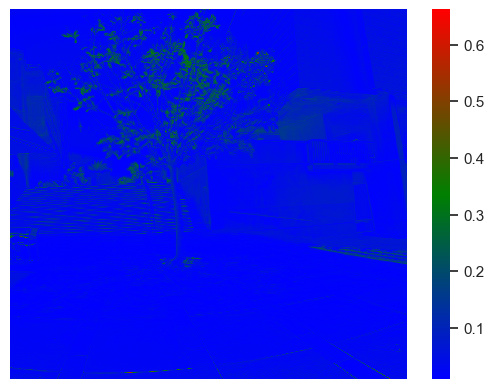

In [28]:
costs_pr_ls = mrae(y_true, y_pred)
costs_pr_ls = np.rot90(costs_pr_ls.reshape(height, width))
sns.heatmap(costs_pr_ls, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()

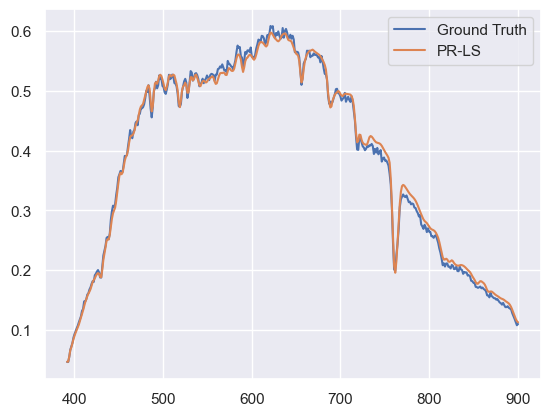

In [29]:
plt.plot(wavelengths, y_true[689675], label='Ground Truth')
plt.plot(wavelengths, y_pred[689675], label='PR-LS')
plt.legend()
plt.show()

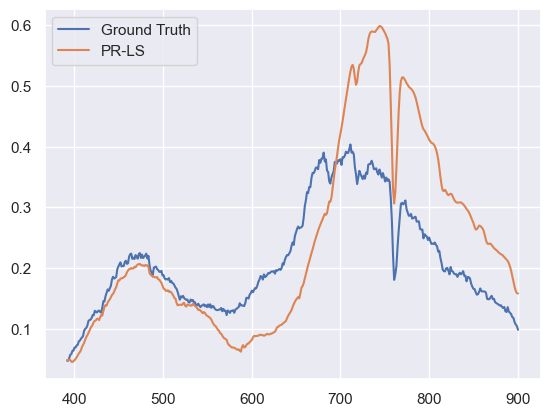

In [30]:
plt.plot(wavelengths, y_true[737945], label='Ground Truth')
plt.plot(wavelengths, y_pred[737945], label='PR-LS')
plt.legend()
plt.show()

In [31]:
del X, y_true, y_pred

## Comparison

In [32]:
costs = [costs_lr_ls, costs_pr_ls]
vmin = min(cost.min() for cost in costs)
vmax = max(cost.max() for cost in costs)

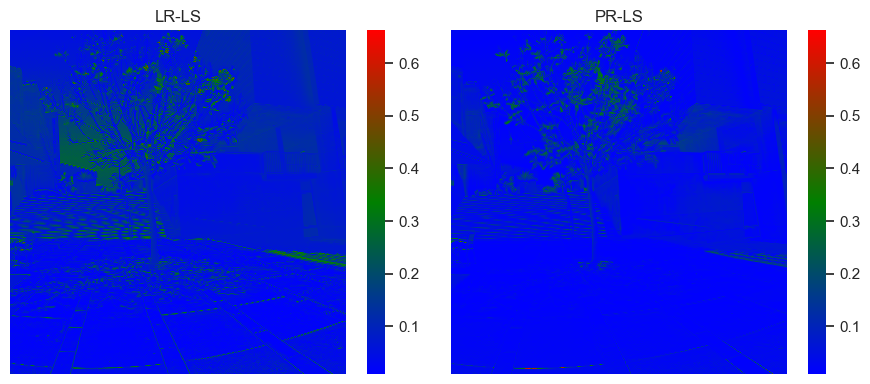

In [35]:
_, axes = plt.subplots(ncols=2, figsize=(9, 4))

sns.heatmap(costs_lr_ls, cmap=cmap, ax=axes[0], vmin=vmin, vmax=vmax)
axes[0].set_title('LR-LS')
axes[0].set_xticks([])
axes[0].set_yticks([])

sns.heatmap(costs_pr_ls, cmap=cmap, ax=axes[1], vmin=vmin, vmax=vmax)
axes[1].set_title('PR-LS')
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()